In [1]:
import os
import sys
sys.path.insert(0, "../../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.text.epu import EPU, UNCERTAINTY_LIST

In [2]:
parent_dirs = sys.path[0] + "data/text/"
country_dirs = [
    parent_dirs + country for country in os.listdir(parent_dirs)
    if country != ".DS_Store" and "marshall_islands" not in country
]
output_dir = sys.path[0] + "outputs/text/"

In [4]:
news_dirs = [
    f"{country_dirs[3]}/{file}" for file in os.listdir(country_dirs[3]) 
    if "news" in file and "ner" not in file
]
e = EPU(news_dirs, cutoff="2020-12-31")
e.get_epu_category(subset_condition="date >= '2015-01-01' and date < '2024-01-01'")

In [5]:
def calculate_word_ratios(sentence,
                          word_list,
                          nlp,
                          allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    if isinstance(sentence, str):
        words = sentence.lower().split()
        doc = nlp(" ".join(word for word in words))
        unique_words = [
            token.lemma_ for token in doc if token.pos_ in allowed_postags
        ]
        total_words = len(unique_words)
        words_count = sum(word in word_list for word in unique_words)
        ratio = words_count / total_words if total_words > 0 else 0
    else:
        ratio = 0

    return ratio

In [6]:
from src.text.utils import lemmatize_sent
import spacy
nlp = spacy.load("en_core_web_sm")

In [7]:
terms_list = [
    "apparently", "assume", "assumption", "believe", "claim", "estimate",
    "apparent", "hope", "hypothesis", "hypothetical", "if", "imagine",
    "indication", "likely", "potential", "potentially", "preferably", "sense",
    "show", "think", "feel", "obvious", "obviously", "can", "could", "seem",
    "latent", "mean", "maybe", "possibly", "possible", "perhaps",
    "possibility", "obscure", "seemingly", "ostensibly", "evasive", "elusive",
    "unstable", "unsettled", "unclear", "vague", "uncertain", "unsure",
    "unknown", "unfamiliar", "improbable", "improbably", "potential",
    "potentially", "preferential", "preferentially", "estimate",
    "questionable", "questionably", "appear", "speculate", "speculation",
    "suggest", "doubt", "doubting", "doubtful", "dubious", "suppose", "expect",
    "expecting", "suspect", "suspecting", "presumably", "supposedly",
    "pretended", "supposed", "putative", "probably", "probable", "point at",
    "perchance", "might", "would", "may", "no clue", "no evidence",
    "uncertainty", "no sign", "not easily", "no clear", "no clarity",
    "not easy", "no possible", "no possibility", "no notion", "no idea",
    "not plausible", "not sure", "not certain", "not probable", "not likely",
    "not credible", "not known", "not familiar", "raise questions", "or",
    "either", "and/or"
]

In [8]:
doc = nlp(" ".join(word for word in terms_list))
unique_words = [
    token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']
]

In [9]:
count_dfs = []
for name, raw in e.raw_files:
    raw["ratio"] = raw["news"].apply(lambda x: calculate_word_ratios(x, unique_words, nlp))
    median = raw[(raw.ratio > 0) & (raw.epu)]["ratio"].median()
    raw["epu_m"] = (raw["epu"] & raw["ratio"] >= median)
    news_count = EPU.get_count(raw, "news")
    epu_m_count = EPU.get_count(raw[raw.epu_m], "epu_m")
    count_df = news_count.merge(epu_m_count, on="ym")
    count_df.columns = [f"{name}_{col}" if col != "ym" else col 
                        for col in count_df.columns]
    count_df["date"] = [pd.to_datetime(f"{i}-01") for i in count_df.ym]
    count_dfs.append(count_df)

In [65]:
from src.text.utils import generate_continous_df
si = pd.DataFrame()
for df in count_dfs:
    min_date = df.date.min()
    max_date = df.date.max()
    df = (generate_continous_df(df, min_date, max_date))
    df = df.drop("ym", axis=1)
    if si.empty:
        si = df
    else:
        si = si.merge(df, how="outer", on="date")
si = si.fillna(0)

In [84]:
names = [i[0] for i in e.raw_files]
news_cols = [f"{i[0]}_news_count" for i in e.raw_files]
si["z_score_weighted"] = 0
si["epu_weighted"] = 0
for name in names:
    nom = f"{name}_news_count"
    denom = f"{name}_epu_m_count"
    si[f"{name}_ratio"] = si[denom].divide(si[nom]).fillna(0)
    si[f"{name}_weight"] = si[nom] / si[news_cols].sum(axis=1)
    std = si[si.date <= "2020-12-31"][[f"{name}_ratio"]].std().values[0]
    si[f"{name}_z_score"] = (si[f"{name}_ratio"].fillna(0) / std).fillna(0)
    si["z_score_weighted"] += si[f"{name}_z_score"].multiply(si[f"{name}_weight"])

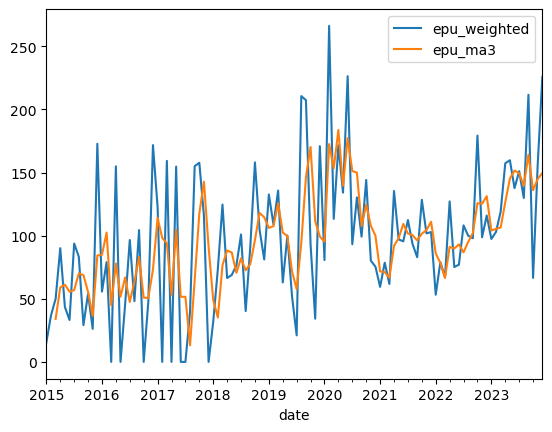

In [93]:
scaling = 100/(si[si.date <= "2020-12-31"]["z_score_weighted"].mean())
si["epu_weighted"] = si["z_score_weighted"].fillna(0) * scaling
si["epu_ma3"] = si["epu_weighted"].rolling(3).mean()
si.plot(x="date", y=["epu_weighted", "epu_ma3"]);

In [96]:
si_cpi = [
    98.6, 99.0, 100.6, 100.7, 101.0, 100.6, 100.5, 100.1, 99.5, 99.6, 99.5,
    100.3, 102.0, 104.2, 103.9, 103.9, 103.0, 102.8, 103.0, 103.2, 104.1,
    104.0, 104.3, 104.4, 104.9, 104.1, 105.7, 104.8, 105.0, 105.1, 105.7,
    105.9, 106.3, 107.0, 107.5, 107.5, 114.2, 114.3, 114.1, 113.4, 112.2,
    107.6, 106.1, 105.3, 105.7, 105.6, 106.0, 104.5, 107.8, 111.6, 113.8,
    111.1, 110.8, 107.6, 106.9, 107.3, 108.0, 108.1, 108.2, 108.7, 109.8,
    110.4, 110.5, 112.7, 114.1, 114.3, 115.6, 117.6, 118.5, 119.8, 119.3,
    118.6, 120.3, 120.1, 120.0, 119.9, 119.6, 119.8, 120.9, 120.7, 120.9
]

si_infl_df = pd.DataFrame(pd.date_range("2017-01", "2023-09", freq="MS"),
                          columns=["date"])
si_infl_df["cpi"] = si_cpi
si_infl = si_infl_df.merge(si[["date", "epu_weighted", "epu_ma3"]],
                           how="left",
                           on="date")
si_infl["inflation"] = (si_infl["cpi"].diff().shift(-1) / si_infl["cpi"]) * 100

In [118]:
from src.tourism.ts_utils import cross_correlation, get_adf_df
get_adf_df(si_infl.dropna(), ["cpi", "epu_weighted", "inflation"])
# cross_correlation(si_infl["epu_ma3"], si_infl["cpi"]).plot(x="lags")

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value 1%,Critical Value 5%,Critical Value 10%
cpi,-0.976490,7.617420e-01,1.0,78.0,-3.517114,-2.899375,-2.586955
epu_weighted,-3.170518,2.175591e-02,3.0,76.0,-3.519481,-2.900395,-2.587498
inflation,-7.049004,5.589499e-10,0.0,79.0,-3.515977,-2.898886,-2.586694


In [158]:
from statsmodels.tsa.api import VAR

length = len(si_infl.iloc[:])
train = int(length * 0.95)
test = length - train


model = VAR(endog=si_infl.loc[:train+1, ["epu_weighted", "inflation"]])

eval_lst = []
for i in range(1, 13):
    result = model.fit(i)
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)
    
eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,1,8.457062,8.639696,4708.576906,8.530114
1,2,8.476479,8.783155,4802.346724,8.599042
2,3,8.525951,8.958548,5049.479103,8.698682
3,4,8.452963,9.013411,4700.306641,8.676533
4,5,8.350219,9.040495,4250.723531,8.625306
5,6,8.325430,9.147560,4160.687472,8.652722
6,7,8.334580,9.290642,4219.623596,8.714776
7,8,8.424061,9.516187,4646.476813,8.857867
8,9,8.452402,9.682780,4825.071269,8.940534
9,10,8.419336,9.790208,4726.871957,8.962517


<module 'matplotlib.pyplot' from '/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/matplotlib/pyplot.py'>

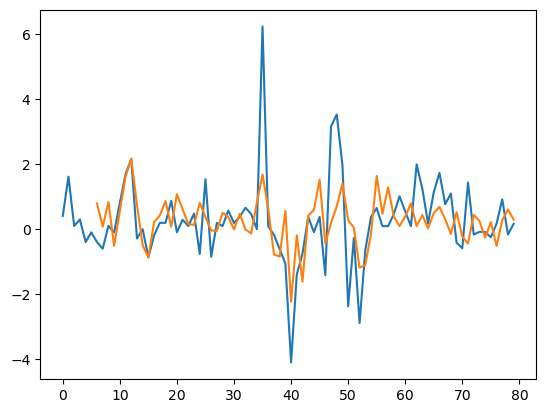

In [159]:
plt.plot(si_infl.loc[:, "inflation"])
plt.plot(res.fittedvalues.iloc[:, 1])
plt

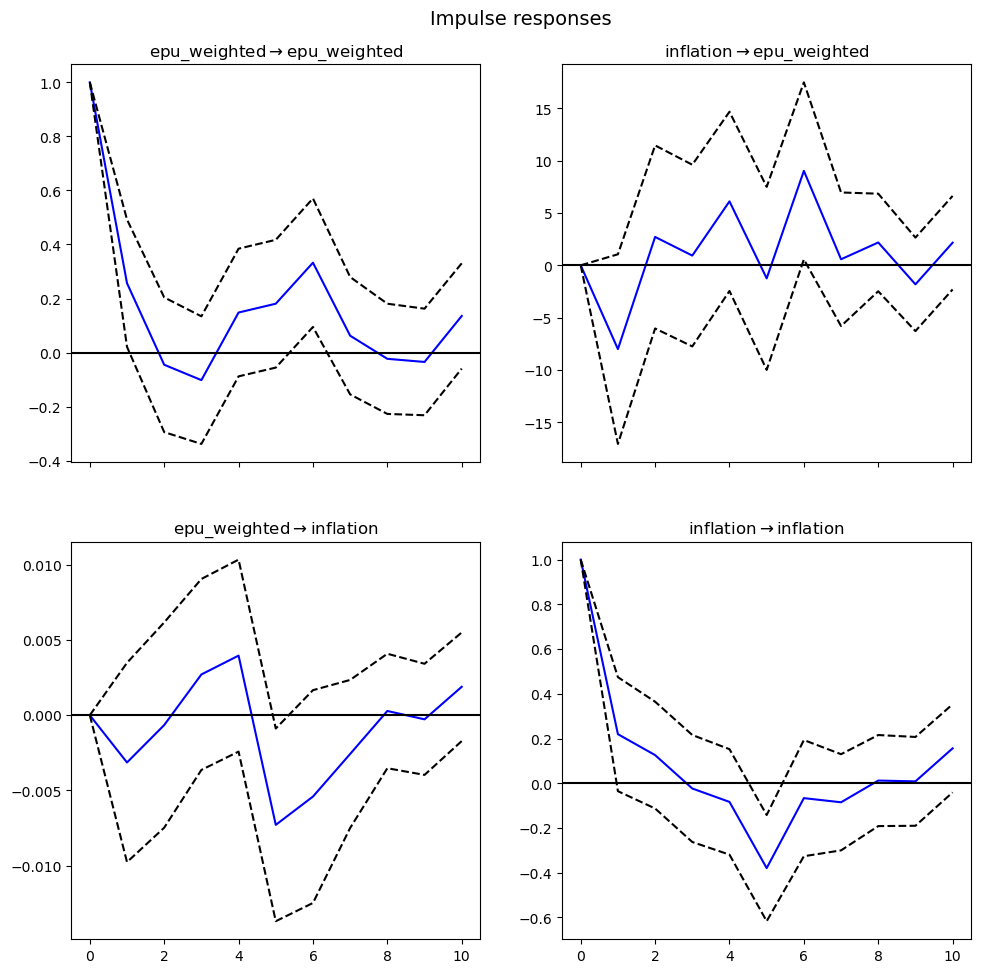

In [162]:
res = model.fit(6)
res.irf().plot();

In [169]:
mod_df = si_infl.dropna()

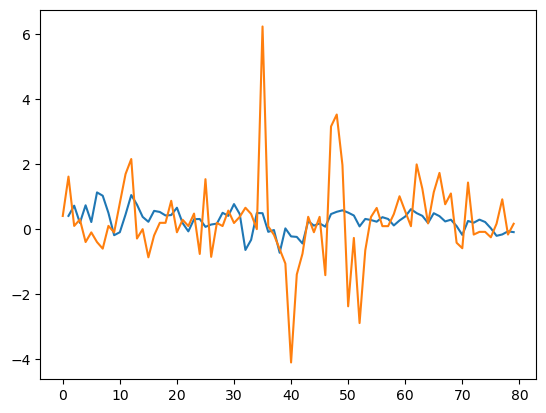

In [194]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

ardl_order = ardl_select_order(endog=mod_df[['inflation']],
                               exog=mod_df[['epu_weighted']],
                               maxlag=12,
                               maxorder=12)
ardl_res = ardl_order.model.fit()
ardl_res.summary()


# ardl_res.fittedvalues
plt.plot(ardl_res.fittedvalues)
plt.plot(mod_df["inflation"].values)